In [1]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, concatenate, Input, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
import csv
import os
import errno
import operator
import sys
import pickle
import random
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib

Using TensorFlow backend.


## read and tokenize training data

In [2]:
user_ids = []
movie_ids = []
ratings = []
with open('data/train.csv', 'rt') as trainfile:
    reader = csv.reader(trainfile, delimiter=',')
    next(reader)
    for row in reader:
        # print(row)
        user_ids.append(row[1])
        movie_ids.append(row[2])
        ratings.append(float(row[3]))
'''
user_ids = np.array(user_ids`)
movie_ids = np.array(movie_ids)
ratings = np.array(ratings)
'''

'\nuser_ids = np.array(user_ids`)\nmovie_ids = np.array(movie_ids)\nratings = np.array(ratings)\n'

In [3]:
print(len(set(user_ids))) # user_ids are continuous
print(len(set(movie_ids))) # some movie ids are not continuous

6040
3688


In [4]:
# takes around 15 seconds
user_tokenizer = Tokenizer()
movie_tokenizer = Tokenizer()

# arg: list of texts
user_tokenizer.fit_on_texts(user_ids)
movie_tokenizer.fit_on_texts(movie_ids)

# arg: list of texts
user_tokens = user_tokenizer.texts_to_sequences(user_ids)
movie_tokens = movie_tokenizer.texts_to_sequences(movie_ids)
# returns: [[1], [2], [3]]
# [[1], [2], [3]] put into embedding layer --> [[wordvec], [wordvec], [wordvec]]

In [5]:
len(user_tokens)

899873

In [6]:
# sanity check
print(np.unique(user_tokens))
print(np.unique(movie_tokens))

[   1    2    3 ..., 6038 6039 6040]
[   1    2    3 ..., 3686 3687 3688]


#### pickle tokenizer

In [167]:
with open('user_tokenizer.pickle', 'wb') as handle:
    pickle.dump(user_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('movie_tokenizer.pickle', 'wb') as handle:
    pickle.dump(movie_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## MF model

In [33]:
model_idx = 0  # for ensemble

In [45]:
for fasdlkfj in range(0,10):
    ids = random.sample(range(0,len(user_tokens)), len(user_tokens))

    batch_size = 10000
    dimension = 50

    use_bias = True

    dirs = {'model_dir': 'for_ensemble'}
    file_name = 'm{}b{}d{}'.format(model_idx, batch_size, dimension) # for ensemble
    model_idx += 1 # for ensemble

    for dir_key in dirs:
        if not os.path.exists(os.getcwd() + '/' + dirs[dir_key]):
            try:
                os.makedirs(os.getcwd() + '/' + dirs[dir_key])
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise

    user_id = Input(shape=(1,))
    user_emb = Embedding(input_dim=len(set(user_ids))+1, output_dim=dimension, input_length=1)(user_id)
    user_emb = Flatten()(user_emb)

    movie_id = Input(shape=(1,))
    movie_emb = Embedding(input_dim=len(set(movie_ids))+1, output_dim=dimension, input_length=1)(movie_id)
    movie_emb = Flatten()(movie_emb)

    user_dot_movie = keras.layers.dot(inputs=[user_emb, movie_emb], axes=1)

    user_b_input = Input(shape=(1,)) # will be np.zeros(1)
    movie_b_input = Input(shape=(1,)) # will be np.zeros(1)
    user_b = Dense(1, input_shape=(1,), use_bias=use_bias)(user_b_input) #  0*W + b
    movie_b = Dense(1, input_shape=(1,), use_bias=use_bias)(movie_b_input)
    rating_pred = keras.layers.add(inputs=[user_dot_movie, user_b, movie_b])

    model = Model(inputs=[user_id, movie_id, user_b_input, movie_b_input], outputs=rating_pred)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    print(model.summary())

    save_model = ModelCheckpoint(dirs['model_dir'] + '/' + file_name
                                 # + '-{epoch:02d}-{val_mean_squared_error:.2f}.hdf5',
                                 + '.hdf5',
                                save_best_only=True)
    model.fit([np.array([user_tokens[i] for i in ids]), np.array([movie_tokens[i] for i in ids]),
               np.zeros((len(user_tokens), 1)), np.zeros((len(movie_tokens), 1))],
              np.array([ratings[i] for i in ids])/5,
              validation_split=0.1, epochs=20, batch_size=batch_size,
             callbacks=[save_model])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_86 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_43 (Embedding)        (None, 1, 50)        302050      input_85[0][0]                   
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 1, 50)        184450      input_86[0][0]                   
__________________________________________________________________________________________________
flatten_43

input_92 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dot_23 (Dot)                    (None, 1)            0           flatten_45[0][0]                 
                                                                 flatten_46[0][0]                 
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 1)            2           input_91[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 1)            2           input_92[0][0]                   
__________________________________________________________________________________________________
add_23 (Add)                    (None, 1)            0           dot_23[0][0]                     
          

809885/809885 [==============================] - 4s 5us/step - loss: 0.4573 - mean_squared_error: 0.4573 - val_loss: 0.3475 - val_mean_squared_error: 0.3475
Epoch 2/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.1896 - mean_squared_error: 0.1896 - val_loss: 0.0576 - val_mean_squared_error: 0.0576
Epoch 3/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 4/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 5/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 6/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epo

Epoch 11/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 12/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 13/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 14/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 15/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 16/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0303 - val_mean_squared_

809885/809885 [==============================] - 1s 1us/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_105 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_106 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 1, 50)        302050      input_105[0][0]                  
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 1, 50)      

input_111 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_112 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
dot_28 (Dot)                    (None, 1)            0           flatten_55[0][0]                 
                                                                 flatten_56[0][0]                 
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 1)            2           input_111[0][0]                  
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 1)            2           input_112[0][0]                  
__________

809885/809885 [==============================] - 4s 5us/step - loss: 0.4561 - mean_squared_error: 0.4561 - val_loss: 0.3431 - val_mean_squared_error: 0.3431
Epoch 2/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.1728 - mean_squared_error: 0.1728 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 3/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 4/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 5/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 6/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0318 - mean_squared_error: 0.0318 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epo

Epoch 11/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 12/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 13/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 14/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 15/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 16/20
809885/809885 [==============================] - 1s 1us/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0301 - val_mean_squared_

809885/809885 [==============================] - 1s 1us/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0313 - val_mean_squared_error: 0.0313


## DNN model

In [72]:
ratings_onehot = keras.utils.to_categorical(np.array(ratings)-1, num_classes=5)

In [95]:
ratings_onehot

array([[ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.]])

#### using additional user and movie data

In [144]:
user_data = {} # { 'user_id': {'age': np[int/60], 'occupation': np[onehot], 'sex': np[onehot]}, etc. }
with open('data/users.csv', 'rt') as userfile:
    next(userfile)
    for line in userfile:
        line_info = line.split('::')
        user_id = line_info[0] # string
        user_sex = np.array([0, 1]) if line_info[1] == 'F' else np.array([1, 0]) # [0,1] for female, [1,0] for male
        user_age = np.array([int(line_info[2]) / 60])
        user_occupation = keras.utils.to_categorical(int(line_info[3]), num_classes=21)[0]
        # user_zipcode = int(line_info[4].strip())    # has weird things like '98107-2117'
        user_data[user_id] = {'sex': user_sex, 'age': user_age,
                              'occupation': user_occupation} # , 'zipcode': user_zipcode}

In [145]:
for a,b in user_data.items():
    print(a,b)
    break

2355 {'occupation': array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'sex': array([0, 1]), 'age': array([ 0.75])}


In [148]:
movie_id_to_category_onehot = {} # {'movie_id': np[onehot]}
category_to_color_id = {'Action': 2, 'Adventure': 3, 'Animation': 16, "Children's": 12,
 'Comedy': 1, 'Crime': 10, 'Documentary': 7, 'Drama': 14, 'Fantasy': 5, 'Film-Noir': 8,
 'Horror': 9, 'Musical': 17, 'Mystery': 15, 'Romance': 4, 'Sci-Fi': 6, 'Thriller': 0,
 'War': 11, 'Western': 13}

with open('data/mymovies.txt', 'rt') as moviefile:
    next(moviefile)
    for line in moviefile:
        line_info = line.split('::')
        movie_id = line_info[0] # string
        line_category = line_info[2].strip().split('|')
        
        movie_category = np.zeros(len(category_to_color_id))
        for category in line_category:
            movie_category[category_to_color_id[category]] = 1
        movie_id_to_category_onehot[movie_id] = movie_category

In [149]:
user_age_all = []
user_occupation_all = []
user_sex_all = []

for user_id in user_ids:
    user_age_all.append(user_data[user_id]['age'])
    user_occupation_all.append(user_data[user_id]['occupation'])
    user_sex_all.append(user_data[user_id]['sex'])
    
movie_category_all = []

for movie_id in movie_ids:
    try:
        movie_category_all.append(movie_id_to_category_onehot[movie_id])
    except:
        print(movie_id)

#### start training

In [140]:
ids = random.sample(range(0,len(user_tokens)), len(user_tokens))

batch_size = 10000
dimension = 50


dirs = {'model_dir': 'DNN_custom'}
file_name = 'b{}d{}'.format(batch_size, dimension)

for dir_key in dirs:
    if not os.path.exists(os.getcwd() + '/' + dirs[dir_key]):
        try:
            os.makedirs(os.getcwd() + '/' + dirs[dir_key])
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

user_id = Input(shape=(1,))
user_emb = Embedding(input_dim=len(set(user_ids))+1, output_dim=dimension, input_length=1)(user_id)
user_emb = Flatten()(user_emb)

movie_id = Input(shape=(1,))
movie_emb = Embedding(input_dim=len(set(movie_ids))+1, output_dim=dimension, input_length=1)(movie_id)
movie_emb = Flatten()(movie_emb)

user_age = Input(shape=(1,))
user_occupation = Input(shape=(21,))
user_sex = Input(shape=(2,))

movie_category = Input(shape=(18,))

concat_user_movie = keras.layers.concatenate(inputs=[user_emb, movie_emb,
                                                     user_age, user_occupation, user_sex, movie_category])

dense_1 = Dense(100)(concat_user_movie)
dense_2 = Dense(100)(dense_1)
output = Dense(1)(dense_2) # for MSE
# output = Dense(5, activation='softmax')(dense_2) # for softmax

model = Model(inputs=[user_id, movie_id, user_age, user_occupation, user_sex, movie_category], outputs=output)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # for softmax
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error']) # for mse
print(model.summary())

save_model = ModelCheckpoint(dirs['model_dir'] + '/' + file_name + 
                             # '-{epoch:02d}-{val_acc:.2f}.hdf5' # for softmax
                             '-{epoch:02d}-{val_mean_squared_error:.2f}.hdf5' # for mse
                            )
class getMSE(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        y_pred = self.model.predict(
            [np.array([user_tokens[i] for i in ids[-int(len(ids)*0.1+1):]]), np.array([movie_tokens[i] for i in ids[-int(len(ids)*0.1+1):]])],
            batch_size = 500
        )
        y_pred_scalar = np.argmax(y_pred, axis=1) + 1
        # print('\ny_pred_scalar', y_pred_scalar)
        y = np.array([ratings[i] for i in ids[-int(len(ids)*0.1+1):]])
        mse = ((y_pred_scalar - y) ** 2).mean()
        print('\nMSE:', mse)
mse_callback = getMSE()
model.fit([np.array([user_tokens[i] for i in ids]), np.array([movie_tokens[i] for i in ids]),
           
          np.array([user_age_all[i] for i in ids]), np.array([user_occupation_all[i] for i in ids]),
           np.array([user_sex_all[i] for i in ids]), np.array([movie_category_all[i] for i in ids])
          ],
          # np.array([ratings_onehot[i] for i in ids]), # for softmax
          np.array([ratings[i] for i in ids])/5, # for MSE
          validation_split=0.1, epochs=50, batch_size=batch_size,
         callbacks=[save_model,
                    # mse_callback # for softmax
                   ])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_157 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_158 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_75 (Embedding)        (None, 1, 50)        302050      input_157[0][0]                  
__________________________________________________________________________________________________
embedding_76 (Embedding)        (None, 1, 50)        184450      input_158[0][0]                  
__________________________________________________________________________________________________
flatten_84

KeyboardInterrupt: 

## read test file

In [153]:
test_user_ids = []
test_movie_ids = []

with open('data/test.csv', 'rt') as testfile:
    reader = csv.reader(testfile, delimiter=',')
    next(reader) # skip headings
    for row in reader:
        test_user_ids.append(row[1])
        test_movie_ids.append(row[2])
print('finished reading file')

finished reading file


In [154]:
print(len(set(test_user_ids)))
print(len(set(test_movie_ids)))

5970
3336


In [155]:
test_user_tokens = [i if i != [] else [0] for i in user_tokenizer.texts_to_sequences(test_user_ids)]
test_movie_tokens = [i if i != [] else [0] for i in movie_tokenizer.texts_to_sequences(test_movie_ids)]

In [156]:
count = 0
oov = set()
for idx, token in enumerate(test_movie_tokens):
    if token == [0] and test_movie_ids[idx] not in oov:
        oov.add(test_movie_ids[idx])
        count += 1
print(oov)
print(count, 'movies not seen in training data')

{'3321', '1709', '3530', '2484', '3472', '3229', '3323', '642', '789', '679', '2258', '530', '1915', '1830', '3607', '398', '3904', '774'}
18 movies not seen in training data


In [157]:
print(len(np.unique(test_user_tokens)))
print(len(np.unique(test_movie_tokens)))

5970
3319


In [158]:
print(np.array(test_user_tokens).shape)
print(np.array(test_movie_tokens).shape)

(100336, 1)
(100336, 1)


#### this part for custom DNN

In [160]:
user_age_test = []
user_occupation_test = []
user_sex_test = []

for user_id in test_user_ids:
    user_age_test.append(user_data[user_id]['age'])
    user_occupation_test.append(user_data[user_id]['occupation'])
    user_sex_test.append(user_data[user_id]['sex'])
    
movie_category_test = []

for movie_id in test_movie_ids:
    try:
        movie_category_test.append(movie_id_to_category_onehot[movie_id])
    except:
        print(movie_id)

## load model, generate predictions

#### ensemble

In [46]:
loaded_models = []
model_names = os.listdir('for_ensemble')
for model_name in model_names:
    loaded_model = load_model('for_ensemble/' + model_name)
    loaded_models.append(loaded_model)
print(len(loaded_models), 'models loaded!')

23 models loaded!


In [ ]:
preds = np.array([[i] for i in np.zeros(len(test_user_tokens))])
for loaded_model in loaded_models:
    single_preds = loaded_model.predict([np.array(test_user_tokens), np.array(test_movie_tokens),
               np.zeros((len(test_user_tokens), 1)), np.zeros((len(test_movie_tokens), 1))], batch_size=500, verbose=1)
    preds += single_preds*5 / len(loaded_models)
print('ensemble prediction with', len(loaded_models), 'models completed!')

In [ ]:
print(preds)

#### single model (this code for custom DNN)

In [143]:
model_name = 'DNN_custom/b10000d50-16-0.03.hdf5'
loaded_model = load_model(model_name)
print('single model loaded!')

single model loaded!


In [164]:
preds = loaded_model.predict([
                                np.array(test_user_tokens), np.array(test_movie_tokens),
    
                                np.array(user_age_test), np.array(user_occupation_test),
                                np.array(user_sex_test), np.array(movie_category_test)
                              ],
                             batch_size=500, verbose=1)
preds *= 5
print('prediction with single model completed!')

100336/100336 [==============================] - 0s 4us/step
prediction with single model completed!


In [165]:
print(preds)

[[ 4.1145649 ]
 [ 4.21151781]
 [ 3.98953199]
 ..., 
 [ 2.51368022]
 [ 3.5310483 ]
 [ 3.67414188]]


## write submission file

In [166]:
with open('custom_DNN.csv', 'wt') as outfile:
    test_writer = csv.writer(outfile)
    test_writer.writerow(['TestDataID','Rating'])
    
    counter = 1
    for i in preds:
        test_writer.writerow([counter, i[0]])
        counter += 1
    
print('finished writing submission!')

finished writing submission!


## t-SNE visualization of movie embeddings

In [131]:
movie_embeddings = np.array(loaded_model.layers[3].get_weights()).reshape(3689, 10)

In [132]:
movie_embeddings.shape

(3689, 10)

In [195]:
# takes 1 minute
movie_TSNE_embeddings = TSNE(n_components=2).fit_transform(movie_embeddings)

In [197]:
movie_TSNE_embeddings.shape

(3689, 2)

In [190]:
movie_id_to_category = {} # e.g. {'1354': 'Drama', '492': 'Comedy'}
with open('data/mymovies.txt', 'rt') as infile:
    next(infile)
    for line in infile:
        line_info = line.split('::')
        # print(line_info)
        movie_id = line_info[0]
        # print(movie_id)
        category = line_info[2].split('|')[0].strip()
        # print(category)
        movie_id_to_category[movie_id] = category

In [78]:
category_to_color_id = {'Action': 2, 'Adventure': 3, 'Animation': 16, "Children's": 12,
 'Comedy': 1, 'Crime': 10, 'Documentary': 7, 'Drama': 14, 'Fantasy': 5, 'Film-Noir': 8,
 'Horror': 9, 'Musical': 17, 'Mystery': 15, 'Romance': 4, 'Sci-Fi': 6, 'Thriller': 0,
 'War': 11, 'Western': 13}

In [289]:
x = []
y = []
label = [] # 18 different categories
for movie_id in set(movie_ids): # movie_ids was created when reading training data
    embedding_id = movie_tokenizer.texts_to_sequences([movie_id]) # need to train user_tokenizer first
    TSNE_embedding = movie_TSNE_embeddings[embedding_id[0][0]]
    x.append(TSNE_embedding[0])
    y.append(TSNE_embedding[1])
    category = movie_id_to_category[movie_id]
    label.append(category_to_color_id[category])

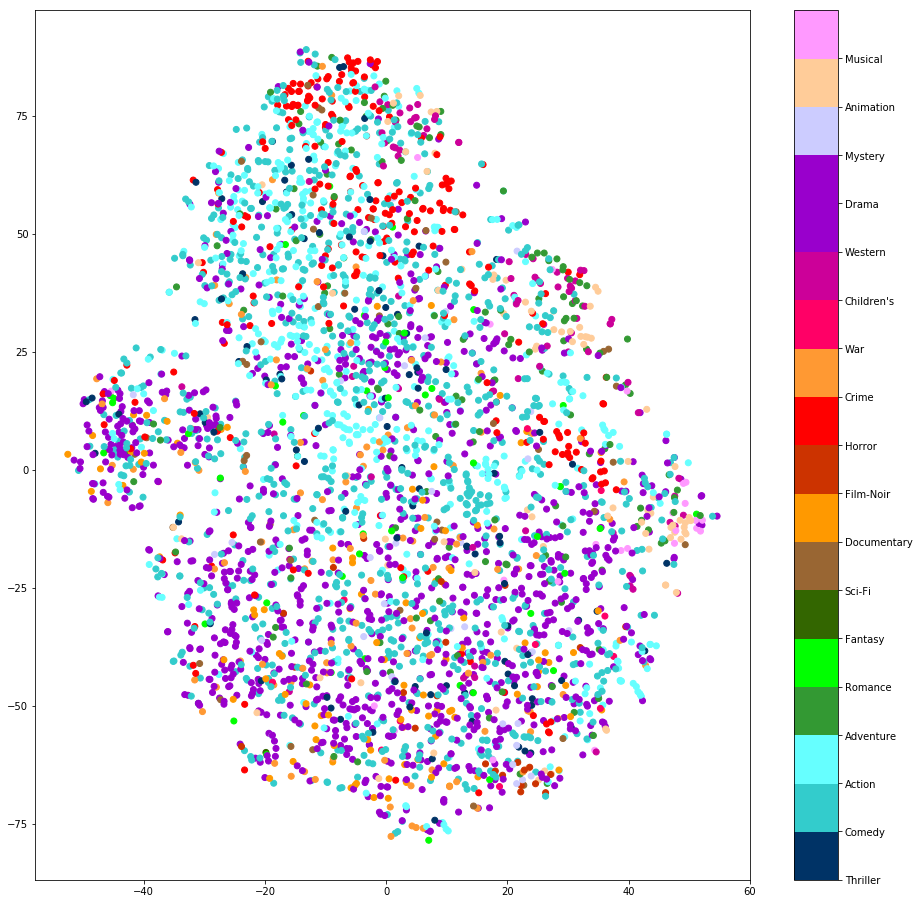

In [291]:
colors = ['#003366','#33cccc','#66ffff', # blue
          '#339933','#00ff00','#336600', # green
          '#996633','#ff9900','#cc3300', # brown
          '#ff0000','#ff9933','#ff0066', # red and orange
          '#cc0099','#9900cc','#9900cc', # purple and yellow
          '#ccccff','#ffcc99','#ff99ff'] # light purple, light orange, light blue

fig = plt.figure(figsize=(16,16))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(categories)
plt.show()